# Part 1: Training a Convolutional Neural Network

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2022-12-09 19:35:34.415558: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'Data','train_val')
test_path  = os.path.join(cwd,'Data','test')

In [3]:
input_train = xr.open_dataset(os.path.join(train_path,'forcing_train_2d.nc'),decode_times=False)
input_test= xr.open_dataset(os.path.join(test_path,'forcing_test_2d.nc'),decode_times=False)
input_train = input_train.sel(x=slice(-3024000,3040000), y=slice(-3024000,3040000))
input_test = input_test.sel(x=slice(-3024000,3040000), y=slice(-3024000,3040000))

In [4]:
output_train = xr.open_dataset(os.path.join(train_path,'member_165_train.nc'))
output_test = xr.open_dataset(os.path.join(test_path,'member_165_test.nc'))

output_train = output_train.sel(x=slice(-3024000,3040000), y=slice(-3024000,3040000))
output_test = output_test.sel(x=slice(-3024000,3040000), y=slice(-3024000,3040000))

In [5]:
y_train_np = output_train['velsurf_mag'].fillna(-1).data
y_test_np  = output_test['velsurf_mag'].fillna(-1).data

In [6]:
X_train_np = input_train.to_array().transpose('time', 'x', 'y', 'variable').data
X_test_np  = input_test.to_array().transpose('time', 'x', 'y', 'variable').data

print(X_train_np.shape,y_train_np.shape,X_test_np.shape,y_test_np.shape)

(300, 380, 380, 1) (300, 380, 380) (100, 380, 380, 1) (100, 380, 380)


In [7]:
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[y_true >=0]
    y_true = y_true[y_true >=0]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1))

In [8]:
n_filters  = 32  # number of filters
n_neurons  = 32  # number of neurons in the Dense layer
activation     = 'relu' # activation function
kernel_size    = 5
learning_rate  = 0.01
minibatch_size = 64
num_epochs     = 50

In [9]:
model = Sequential()
model.add(Input(shape=(X_train_np.shape[1],X_train_np.shape[2],X_train_np.shape[3])))
model.add(Conv2D(n_filters, (kernel_size, kernel_size), padding="same", activation=activation))
model.add(Conv2D(n_filters, (kernel_size, kernel_size), padding="same", activation=activation))


model.add(Conv2DTranspose(filters=1, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) 
model.add(MaxPooling2D(
    pool_size=(2, 2), strides=None, padding="valid"))
#model.add(Reshape((1, X_train_np.shape[1], X_train_np.shape[2])))
model.compile(loss=custom_rmse,optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 380, 380, 32)      832       
                                                                 
 conv2d_1 (Conv2D)           (None, 380, 380, 32)      25632     
                                                                 
 conv2d_transpose (Conv2DTra  (None, 760, 760, 1)      801       
 nspose)                                                         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 380, 380, 1)      0         
 )                                                               
                                                                 
Total params: 27,265
Trainable params: 27,265
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train_np, y_train_np, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/50
4/4 [==============================] - 63s 10s/step - loss: 222.9990 - val_loss: 141.0037
Epoch 2/50
4/4 [==============================] - 2s 461ms/step - loss: 183.7759 - val_loss: 138.4730
Epoch 3/50
4/4 [==============================] - 2s 462ms/step - loss: 182.8535 - val_loss: 139.6319
Epoch 4/50
4/4 [==============================] - 2s 464ms/step - loss: 182.4129 - val_loss: 142.3094
Epoch 5/50
4/4 [==============================] - 2s 462ms/step - loss: 182.4345 - val_loss: 143.8634
Epoch 6/50
4/4 [==============================] - 2s 460ms/step - loss: 182.4710 - val_loss: 140.5374
Epoch 7/50
4/4 [==============================] - 2s 463ms/step - loss: 181.8593 - val_loss: 138.5158
Epoch 8/50
4/4 [==============================] - 2s 460ms/step - loss: 181.5923 - val_loss: 138.6558
Epoch 9/50
4/4 [==============================] - 2s 466ms/step - loss: 181.4651 - val_loss: 139.0866
Epoch 10/50
4/4 [==============================] - 2s 467ms/step - loss: 181.4572 -

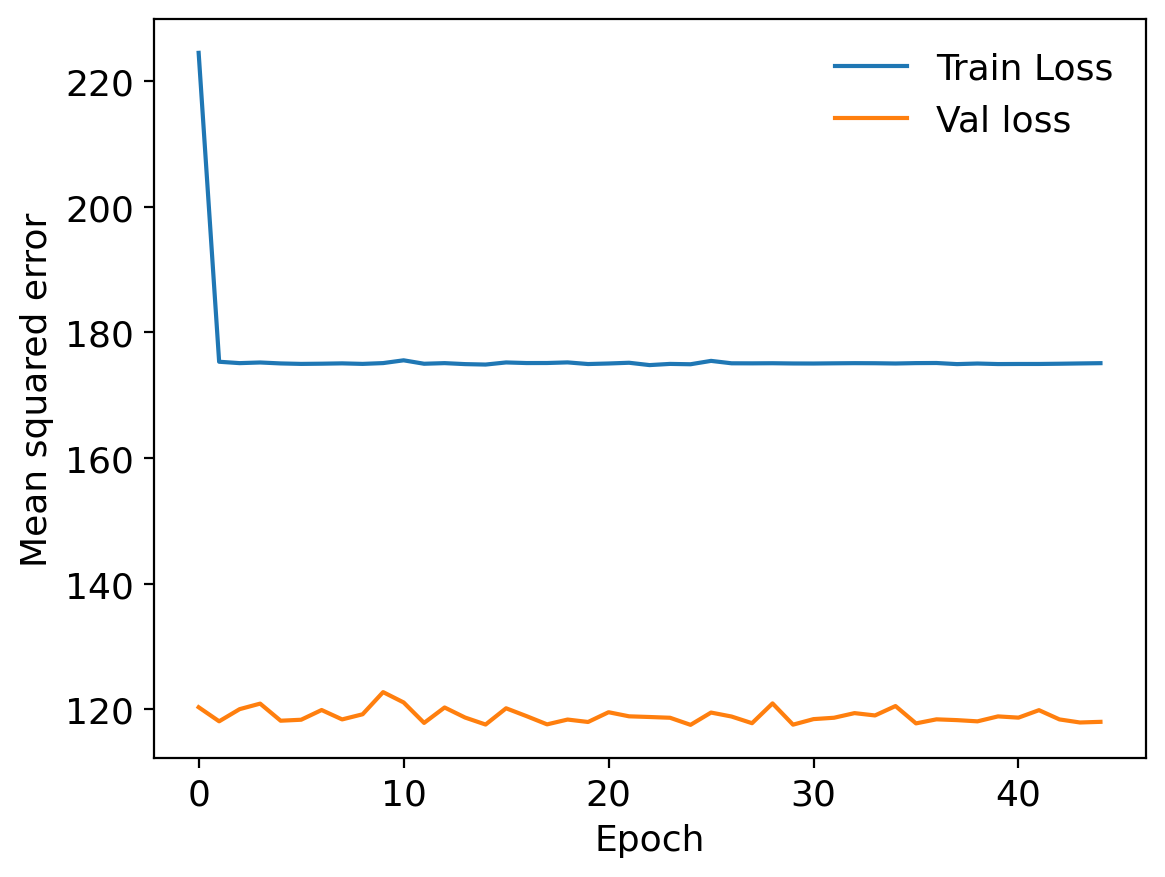

In [53]:
plot_history(history)

In [15]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [59]:
model.save(os.path.join(model_path,'CNN_model_1_member.h5'))

## Testing

In [60]:
model = load_model(os.path.join(model_path,'CNN_model_1_member.h5'),custom_objects={'custom_rmse':custom_rmse})

In [58]:
y_test_pre = model.predict(X_test_np)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 380, 380)
y_test_pre = xr.Dataset(coords={'time': input_test.time, 
                               'x': input_test.x.values, 
                               'y': input_test.y.values},
                       data_vars=dict(velsurf_mag=(['time', 'y', 'x'], y_test_pre)))

8/8 [==============================] - 0s 60ms/step


In [59]:
y_true =  output_test

In [60]:
y_true

<xarray.Dataset>
Dimensions:      (time: 249, bnds: 2, x: 380, y: 380)
Coordinates:
  * time         (time) float64 -2.47e+04 -2.46e+04 -2.45e+04 ... 0.0 50.0
  * x            (x) float64 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * y            (y) float64 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
Dimensions without coordinates: bnds
Data variables:
    time_bnds    (time, bnds) float64 ...
    velsurf_mag  (time, y, x) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.5 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.9.5 (http://mpimet.mpg.de/...
    history:      Sun Nov 13 20:28:46 2022: ncatted -O -a history_of_appended...
    NCO:          netCDF Operators version 4.7.8 (Homepage = http://nco.sf.ne...

In [62]:
y_test_pre = y_test_pre+y_true-y_true

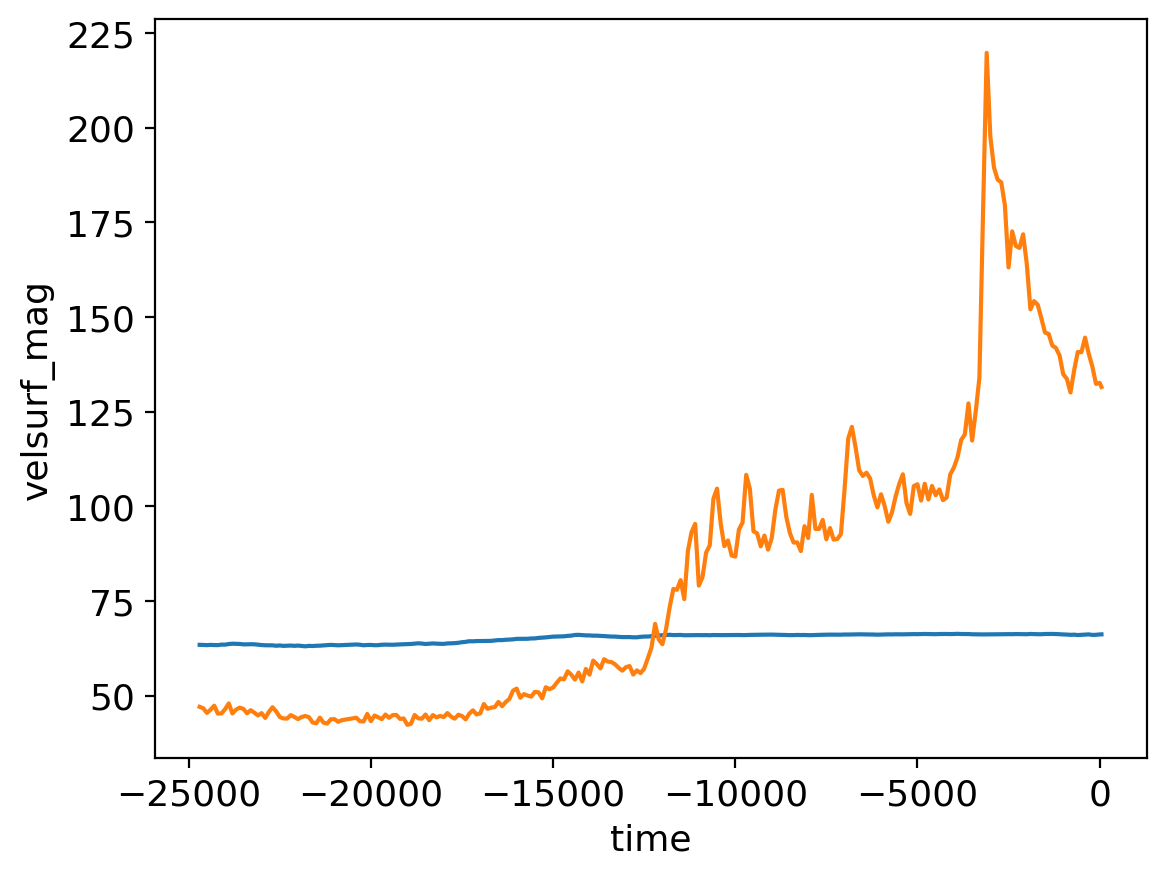

In [65]:
y_test_pre.velsurf_mag.mean(dim=['x','y']).plot()
y_true.velsurf_mag.mean(dim=['x','y']).plot()

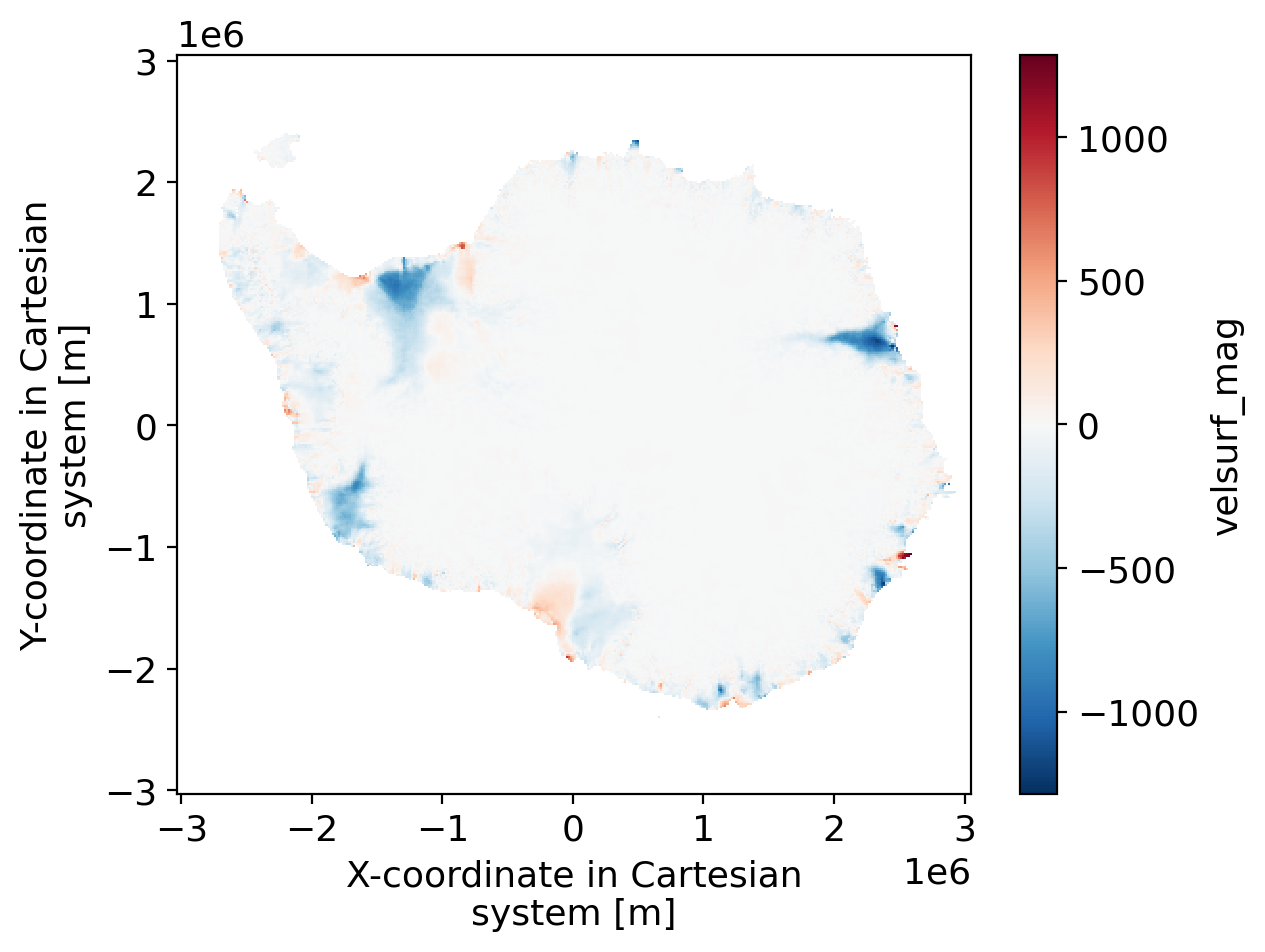

In [46]:
(y_true-y_test_pre_xr.velsurf_mag).mean(dim='time').plot()

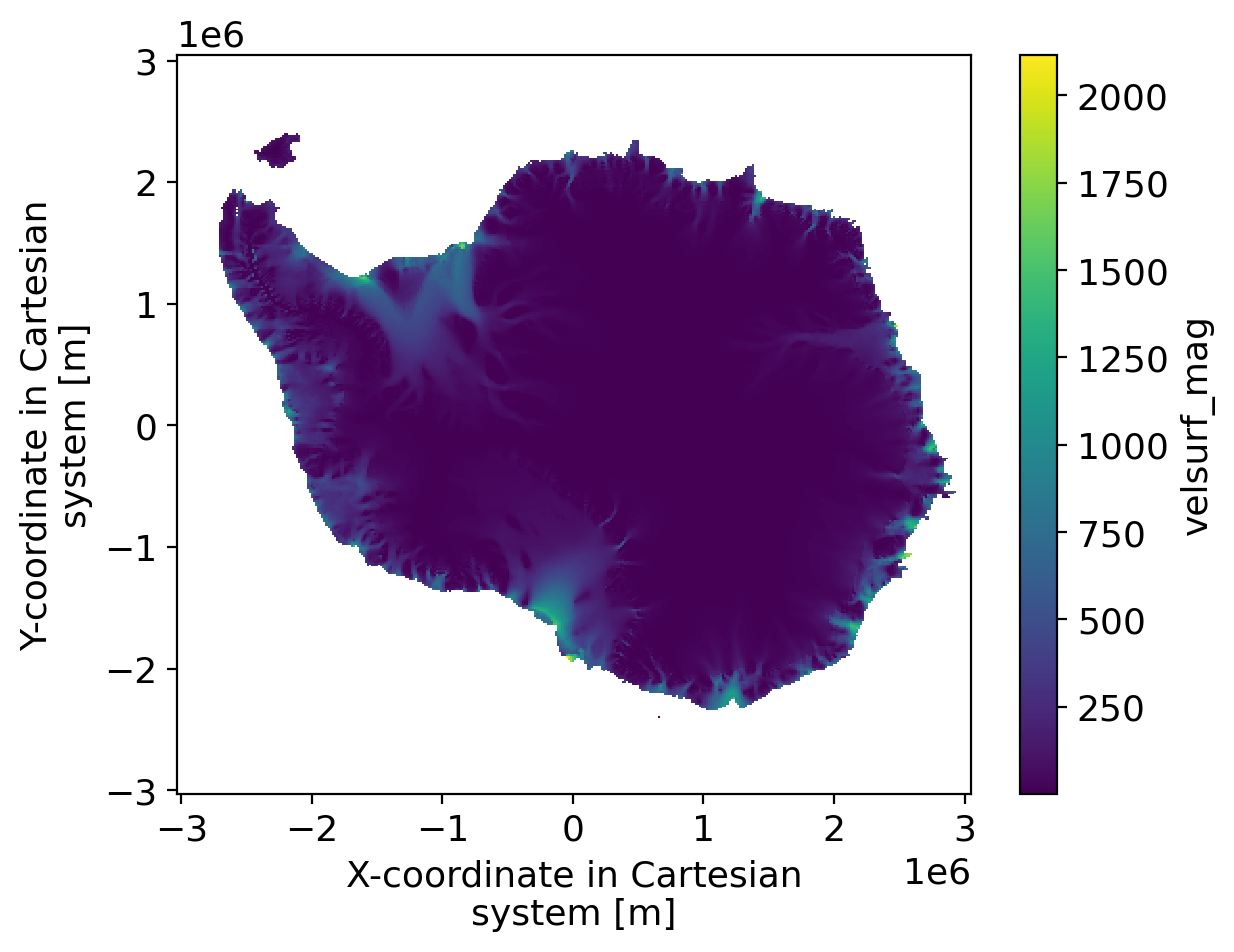

In [47]:
y_true.mean(dim='time').plot()

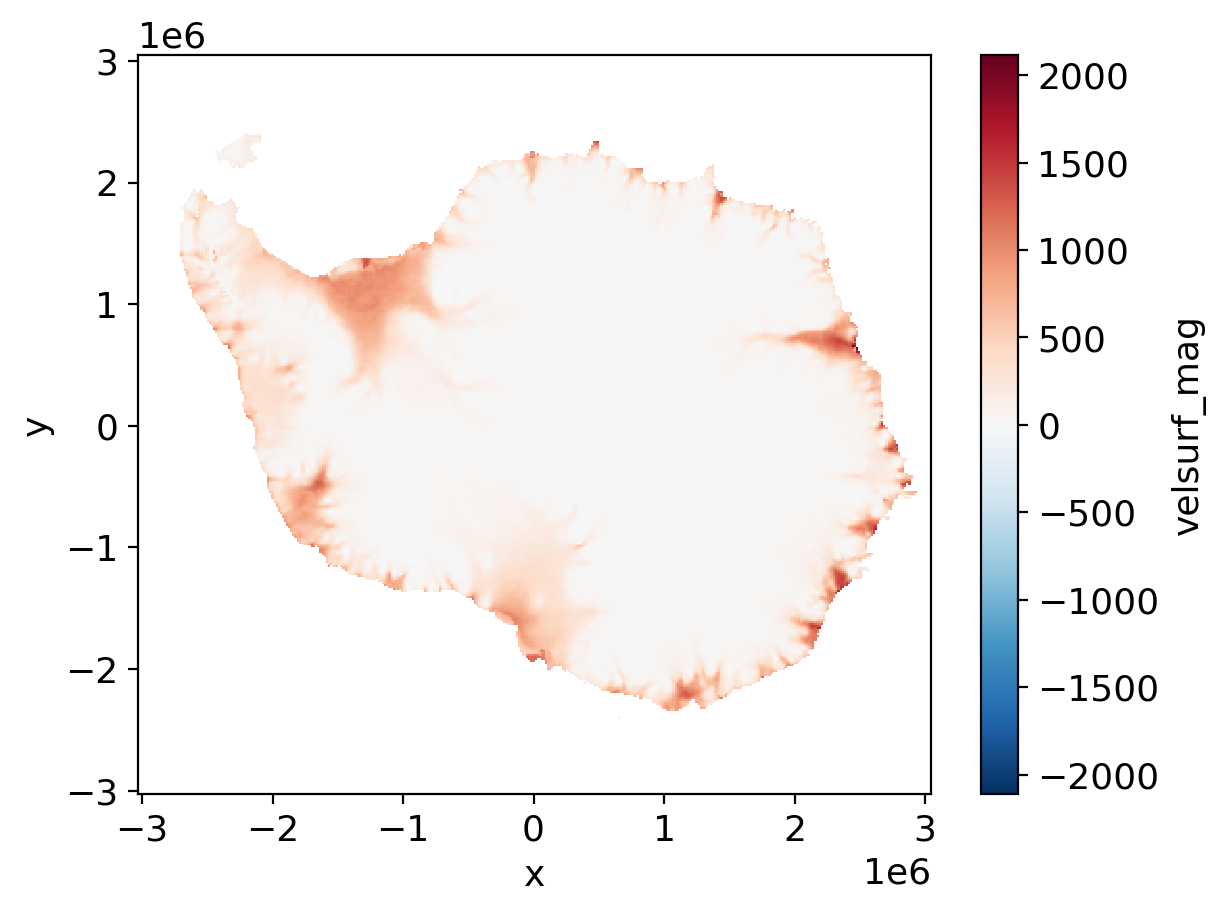

In [48]:
y_test_pre_xr.velsurf_mag.mean(dim='time').plot()

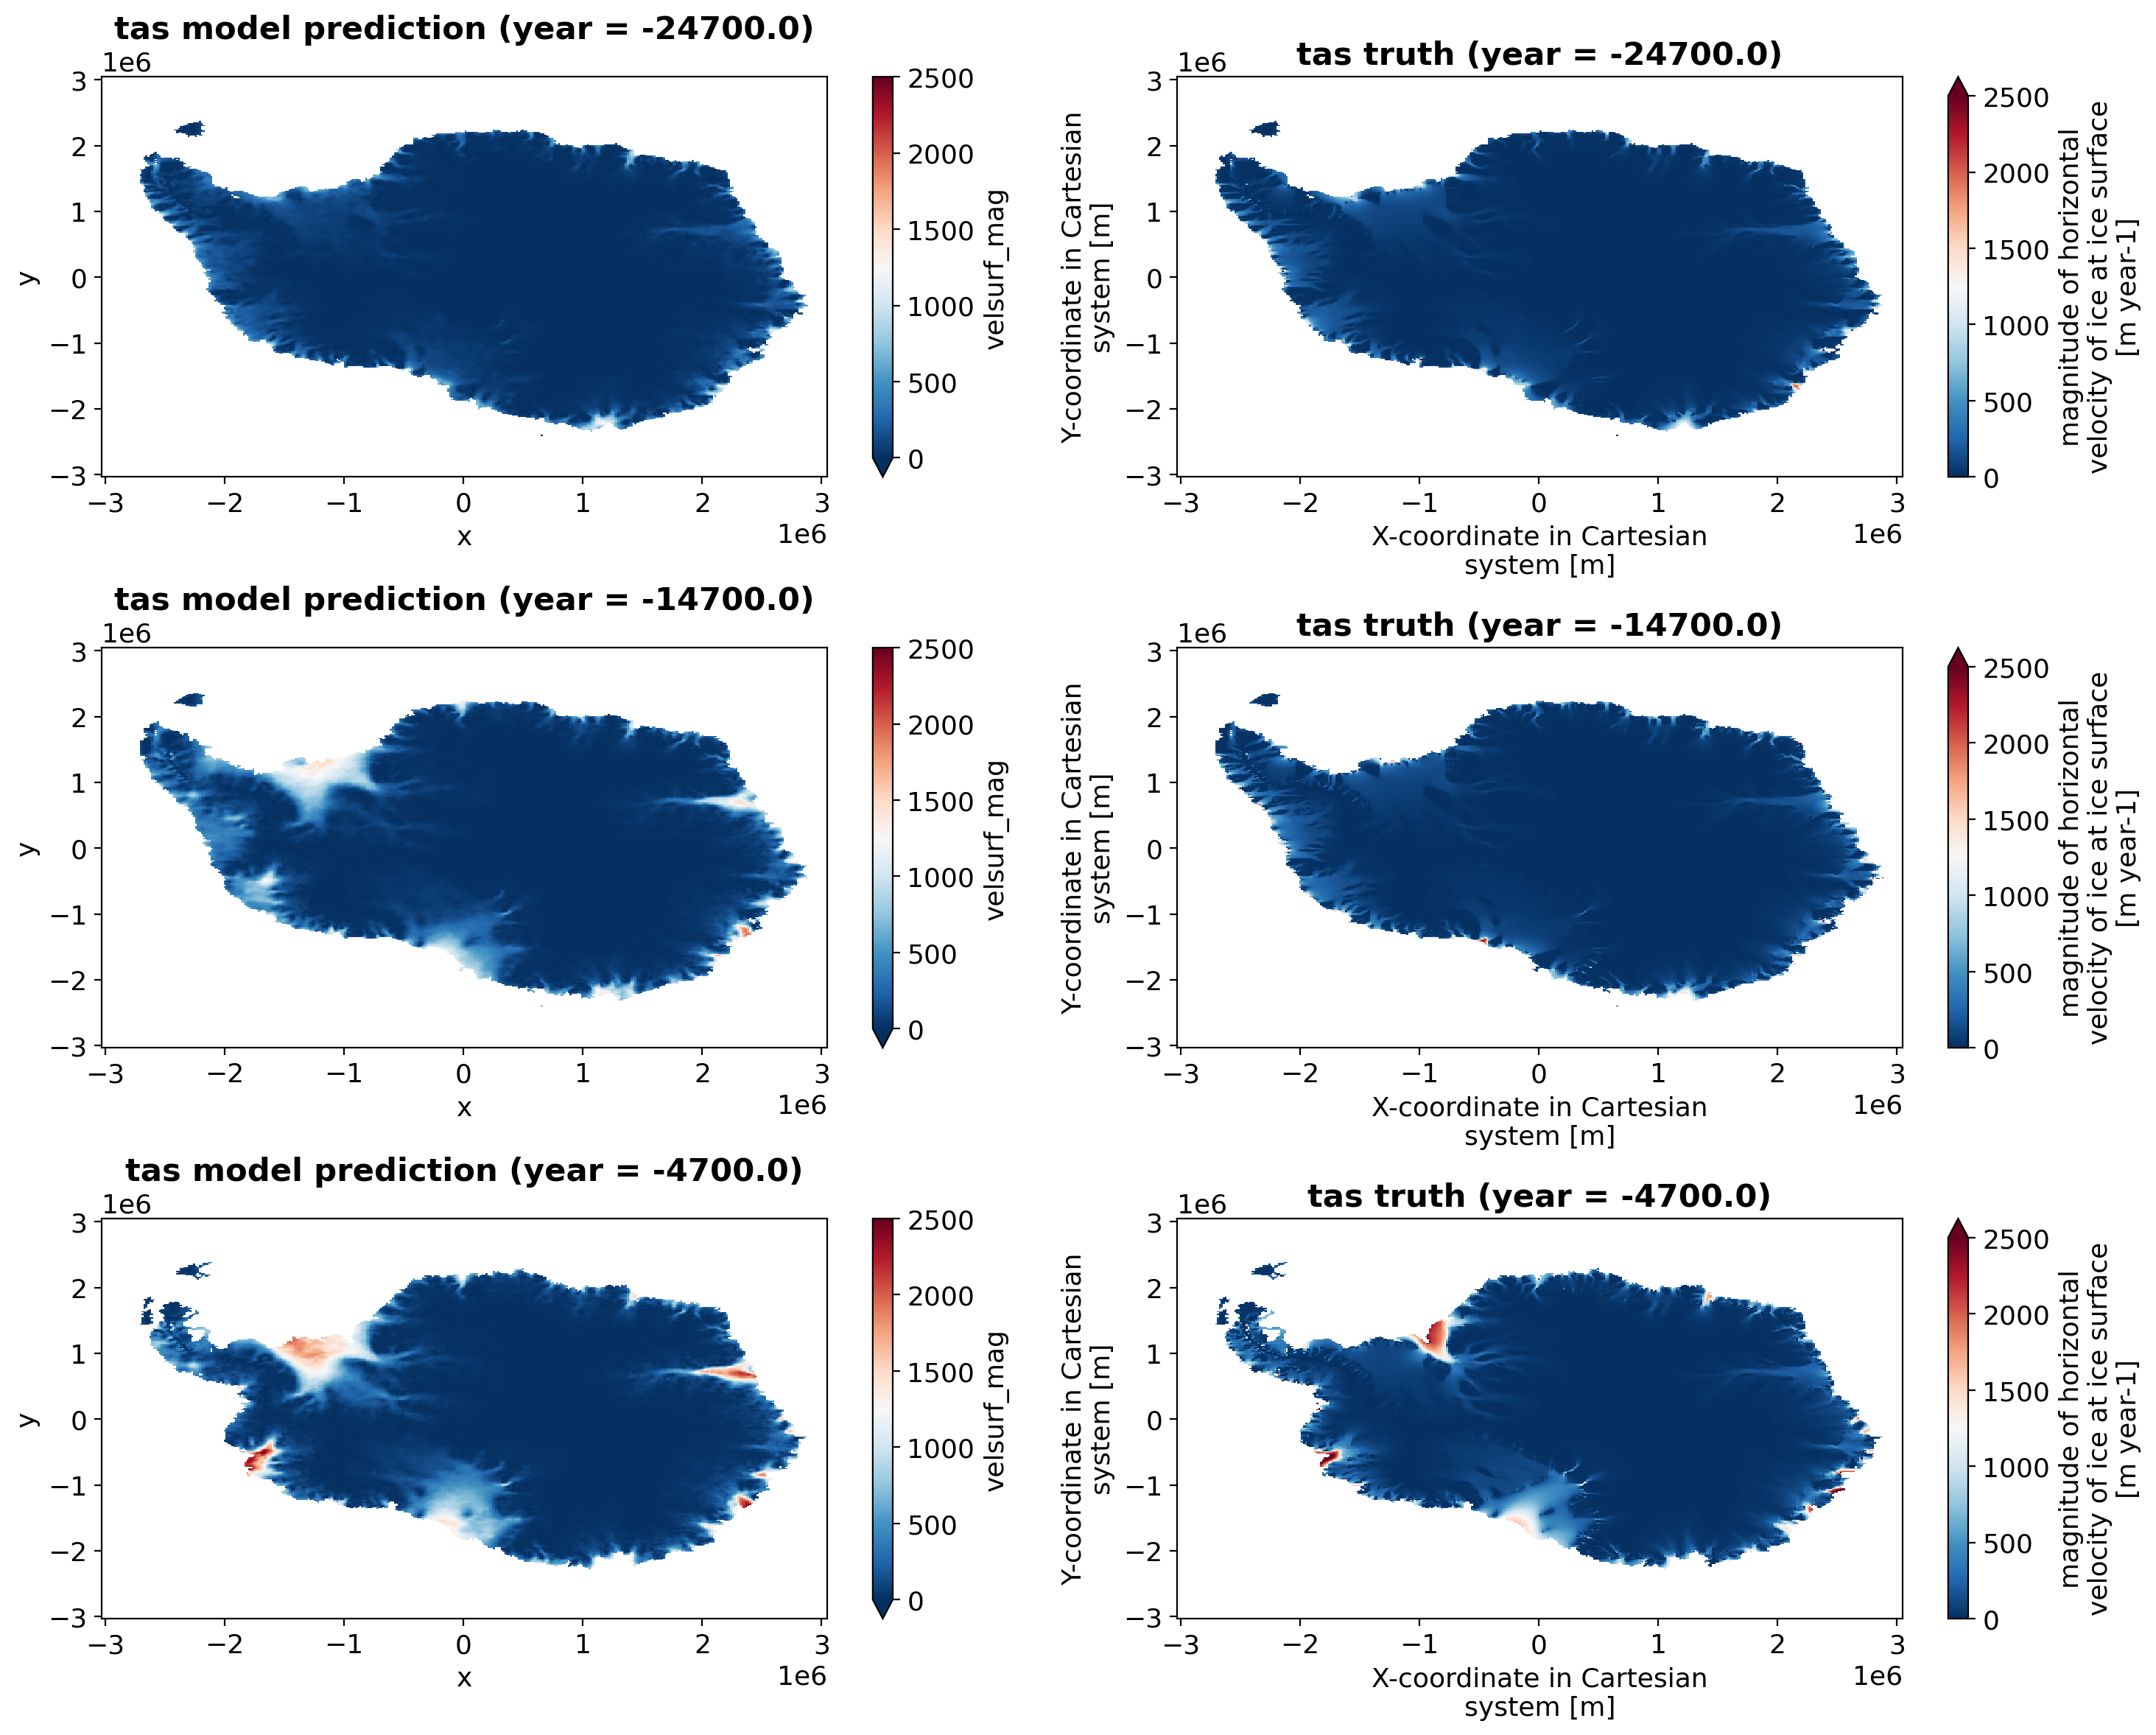

In [49]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [y_test_pre_xr.time[0].values, y_test_pre_xr.time[100].values, y_test_pre_xr.time[200].values]
vmin, vmax    = 0, 2500
cmap = 'RdBu_r'
y_test_pre_xr.velsurf_mag.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_true.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre_xr.velsurf_mag.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_true.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre_xr.velsurf_mag.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_true.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()